# Imports

In [2]:
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.decomposition import PCA

import torch 
from torch import nn
from torch import optim

import numpy as np


import matplotlib.pyplot as plt
# Word2Vec
import nltk
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec

# Import Data

In [3]:
# Load the training and validation data

train = pd.read_csv('data/public_data/train/track_a/eng.csv')

train.head()

,id,text,Anger,Fear,Joy,Sadness,Surprise
0,eng_train_track_a_00001,But not very happy.,0,0,1,1,0
1,eng_train_track_a_00002,Well she's not gon na last the whole song like...,0,0,1,0,0
2,eng_train_track_a_00003,She sat at her Papa's recliner sofa only to mo...,0,0,0,0,0
3,eng_train_track_a_00004,"Yes, the Oklahoma city bombing.",1,1,0,1,1
4,eng_train_track_a_00005,They were dancing to Bolero.,0,0,1,0,0


In [4]:
emotion2label = {'Anger': 0, 'Fear': 1, 'Joy': 2, 'Sadness': 3, 'Surprise': 4}
label2emotion = {v: k for k, v in emotion2label.items()}
emotions = list(emotion2label.keys())


# Clean Data

In [5]:
train_X = train["text"].str.lower()
train_X = train_X.str.replace(r'[^\w\s]', '') # remove punctuation
train_X = train_X.str.replace(r'\d+', '') # remove numbers
train_X = train_X.str.replace(r'\t', '') # remove tabs
train_X = train_X.str.replace(r'\s+', ' ') # remove extra spaces


train_Y = train[emotions].values

C:\Users\nuni1\AppData\Local\Temp\ipykernel_23012\1588184662.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_X = train_X.str.replace(r'[^\w\s]', '') # remove punctuation
C:\Users\nuni1\AppData\Local\Temp\ipykernel_23012\1588184662.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  train_X = train_X.str.replace(r'\d+', '') # remove numbers
C:\Users\nuni1\AppData\Local\Temp\ipykernel_23012\1588184662.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  train_X = train_X.str.replace(r'\t', '') # remove tabs
C:\Users\nuni1\AppData\Local\Temp\ipykernel_23012\1588184662.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  train_X = train_X.str.replace(r'\s+', ' ') # remove extra spaces


# Generate Embedding

# Word2Vec

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\nuni1\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


['but', 'not', 'very', 'happy', 'well', 'shes', 'not', 'gon', 'na', 'last', 'the', 'whole', 'song', 'like', 'that', 'so', 'since', 'im', 'behind', 'her', 'and', 'the', 'audience', 'cant', 'see', 'below', 'my', 'torso', 'pretty', 'much', 'i', 'use', 'my', 'hand', 'to', 'push', 'down', 'on', 'the', 'lid', 'and', 'support', 'her', 'weight', 'she', 'sat', 'at', 'her', 'papas', 'recliner', 'sofa', 'only', 'to', 'move', 'next', 'to', 'me', 'and', 'start', 'clinging', 'to', 'my', 'arms', 'yes', 'the', 'oklahoma', 'city', 'bombing', 'they', 'were', 'dancing', 'to', 'bolero', 'still', 'had', 'sex', 'with', 'her', 'though', 'but', 'i', 'am', 'exhaustedmy', 'eyes', 'feel', 'like', 'they', 'are', 'about', 'to', 'pop', 'out', 'of', 'my', 'headi', 'need', 'some', 'soothing', 'music', 'and', 'images', 'to', 'help', 'my', 'mediate', 'even', 'for', 'a', 'few', 'minutes', 'just', 'take', 'me', 'away', 'yoga', 'mondays', 'musical', 'meditation', 'minutes', 'ago', 'early', 'nightfirst', 'day', 'of', 'work

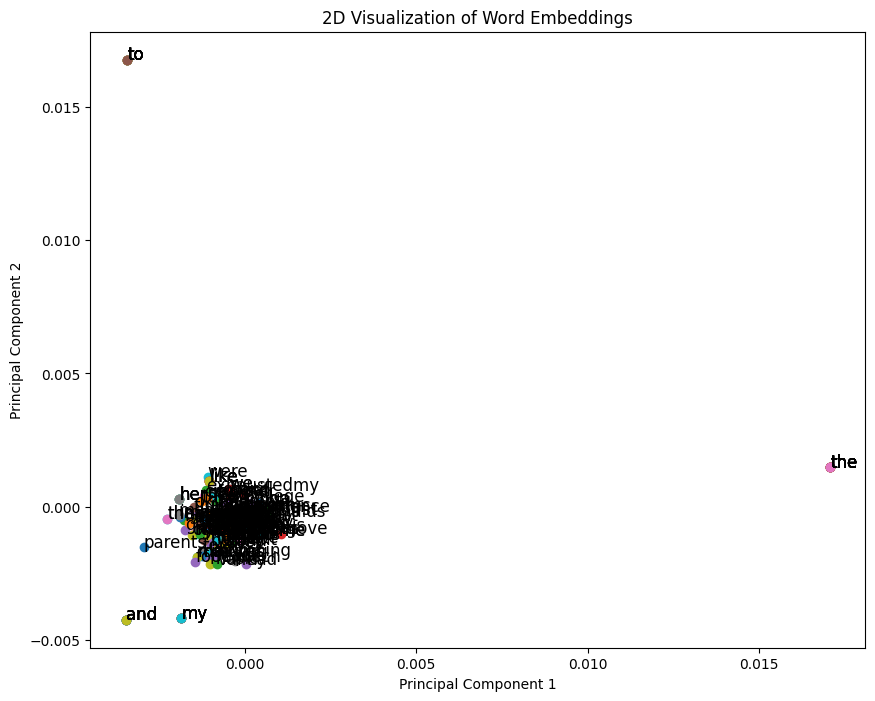

In [6]:
embedding_dim = 1024
window_size = 200
min_word_count = 0
workers = 8

nltk.download('punkt_tab')

print([word for sentence in train_X for word in sentence.split(" ")])
tokens = [word_tokenize(word) for sentence in train_X for word in sentence.split(" ")]


# TODO: Train Word2Vec model with 'Word2Vec'
word2vec_model = Word2Vec(sentences=[*tokens], vector_size=embedding_dim, window=window_size,
                          min_count=min_word_count, workers=workers)
print("Word2Vec model training complete.")
train_X_emb = [[word2vec_model.wv[word] for word in sentence.split(" ") if word in word2vec_model.wv] for sentence in train_X]

words_to_visualize = [(word) for sentence in train_X[:10] for word in sentence.split(" ")]
print(words_to_visualize)
word_vectors = [word2vec_model.wv[word] for word in words_to_visualize]



pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(word_vectors)

# Plot the word vectors
plt.figure(figsize=(10, 8))
for i, word in enumerate(words_to_visualize):
    plt.scatter(reduced_vectors[i][0], reduced_vectors[i][1])
    plt.annotate(word, xy=(reduced_vectors[i][0], reduced_vectors[i][1]), fontsize=12)
plt.title("2D Visualization of Word Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

# Bag of Words

In [7]:
vectorizer = CountVectorizer(ngram_range=(1,2))
train_X_emb = vectorizer.fit_transform(train_X).toarray()

# Cast to Tensors

In [8]:
train_X_t = torch.Tensor(train_X_emb)
train_Y_t = torch.Tensor(train_Y)

print(train_X_t.shape, train_Y_t.shape)

_ = [print(f' - {e}: {v} ({(100*v/len(train_Y_t)).round()}%)') for e,v in zip(emotions, train_Y_t.sum(axis=0))]


torch.Size([2768, 28988]) torch.Size([2768, 5])
 - Anger: 333.0 (12.0%)
 - Fear: 1611.0 (58.0%)
 - Joy: 674.0 (24.0%)
 - Sadness: 878.0 (32.0%)
 - Surprise: 839.0 (30.0%)


# Setup BERT Model

In [9]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import seaborn as sns
import transformers
import json
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer, TrainingArguments, Trainer
import logging
logging.basicConfig(level=logging.ERROR)

In [10]:
%pip install transformers==3.0.2

  Using cached transformers-3.0.2-py3-none-any.whl.metadata (44 kB)
  Using cached tokenizers-0.8.1rc1.tar.gz (97 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached sentencepiece-0.2.0-cp310-cp310-win_amd64.whl.metadata (8.3 kB)
  Using cached sacremoses-0.1.1-py3-none-any.whl.metadata (8.3 kB)
Using cached transformers-3.0.2-py3-none-any.whl (769 kB)
Using cached sentencepiece-0.2.0-cp310-cp310-win_amd64.whl (991 kB)
Using cached sacremoses-0.1.1-py3-none-any.whl (897 kB)
Failed to build tokenizers
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × Building wheel for tokenizers (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [54 lines of output]
      C:\Users\nuni1\AppData\Local\Temp\pip-build-env-qu_iqk5o\overlay\Lib\site-packages\setuptools\dist.py:330: InformationOnly: Normalizing '0.8.1.rc1' to '0.8.1rc1'
        self.metadata.version = self._normalize_version(self.metadata.version)
      running bdist_wheel
      running build
      running build_py
      creating build\lib.win-amd64-cpython-310\tokenizers
      copying tokenizers\__init__.py -> build\lib.win-amd64-cpython-310\tokenizers
      creating build\lib.win-amd64-cpython-310\tokenizers\models
      copying tokenizers\models\__init__.py -> build\lib.win-amd64-cpython-310\tokenizers\models
      creating build\lib.win-amd64-cpython-310\tokenizers\decoders
      copying tokenizers\decoders\__init__.py -> build\lib.win-amd64-cpython-310\tokenizers\decoders
      creating build\lib.win-amd64-cpython-310\toke

In [11]:
# Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [ ]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 256
TRAIN_BATCH_SIZE = 2
VALID_BATCH_SIZE = 2
# EPOCHS = 1
LEARNING_RATE = 1e-05
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', truncation=True, do_lower_case=True)

In [113]:
class SentimentDataSet(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer:RobertaTokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text
        self.anger= self.data.Anger
        self.fear= self.data.Fear
        self.joy= self.data.Joy
        self.sadness= self.data.Sadness
        self.surprise= self.data.Surprise
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]
        
        targets = torch.tensor([self.anger[index], self.fear[index], self.joy[index], self.sadness[index], self.surprise[index]], dtype=torch.float)


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'anger': torch.tensor(self.anger[index], dtype=torch.float),
            'fear': torch.tensor(self.fear[index], dtype=torch.float),
            'joy': torch.tensor(self.joy[index], dtype=torch.float),
            'sadness': torch.tensor(self.sadness[index], dtype=torch.float),
            'surprise': torch.tensor(self.surprise[index], dtype=torch.float),
            'targets': targets,
            'text': text
        }

In [114]:
train = pd.read_csv('data/public_data/train/track_a/eng.csv')

train = train.dropna()
train = train.drop(0)
train = train.reset_index(drop=True)

training_set, validation_set = train_test_split(train, test_size=0.2, random_state=123)
training_set = training_set.reset_index(drop=True)
validation_set = validation_set.reset_index(drop=True)

training_set_set = SentimentDataSet(training_set, tokenizer, MAX_LEN)
validation_set_set = SentimentDataSet(validation_set, tokenizer, MAX_LEN)

# validate the dataset

print(f"{training_set_set[12]['text']}: {training_set_set[12]['targets']}")

I swing my foot back, then proceed to apply a good, strong kick to the underside of the table.: tensor([1., 0., 0., 0., 0.])


In [115]:
train_dataloader = DataLoader(training_set_set, batch_size=TRAIN_BATCH_SIZE, num_workers=0)

val_dataloader = DataLoader(validation_set_set, batch_size=VALID_BATCH_SIZE, num_workers=0)

In [116]:
class RobertaClass(torch.nn.Module):
    def __init__(self):
        super(RobertaClass, self).__init__()
        self.l1 = RobertaModel.from_pretrained("roberta-base")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 5)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        classifier = self.classifier(pooler)
        output = self.sigmoid(classifier)
        return output

In [117]:
model = RobertaClass()
model.to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaClass(
  (l1): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNo

In [118]:
# test the model
input_ids = training_set_set[10]['ids'].unsqueeze(0).to(device)
input_mask = training_set_set[10]['mask'].unsqueeze(0).to(device)
token_type_ids = training_set_set[10]['token_type_ids'].unsqueeze(0).to(device)

output = model(input_ids, input_mask, token_type_ids)
output

loss_fn = nn.BCEWithLogitsLoss()
loss_fn = loss_fn.to(device)
loss = loss_fn(output, training_set_set[10]['targets'].unsqueeze(0).to(device))
loss

tensor(0.7780, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [119]:
def calc_accuracy(X, y):
    y_pred = torch.sigmoid(X)
    y_pred = torch.round(y_pred)
    correct = (y_pred == y).float()
    accuracy = correct.sum() / len(correct)
    return accuracy

In [120]:
%pip install 'accelerate>=0.26.0'

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: "'accelerate": Expected package name at the start of dependency specifier
    'accelerate
    ^

[notice] A new release of pip is available: 24.1.1 -> 24.3.1
[notice] To update, run: C:\Users\nuni1\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [121]:
def tokenize(data):
    return tokenizer(
            data,
            add_special_tokens=True,
            padding=True,
            return_token_type_ids=True
        )
 

    

train_targets = torch.tensor(
    list(zip(
        training_set["Anger"],
        training_set["Fear"],
        training_set["Joy"],
        training_set["Sadness"],
        training_set["Surprise"]
    )),
    dtype=torch.float
)

val_targets = torch.tensor(
    list(zip(
        validation_set["Anger"],
        validation_set["Fear"],
        validation_set["Joy"],
        validation_set["Sadness"],
        validation_set["Surprise"]
    )),
    dtype=torch.float
)


def prepare_data(text, label):
    tokenized = tokenizer(text, truncation=True, add_special_tokens=True,padding='max_length', max_length=MAX_LEN,return_token_type_ids=True, return_tensors="pt")
    tokenized['labels'] = label
    return tokenized

tokenized_train = [
    prepare_data(text, label) for text, label in zip(training_set["text"], train_targets)
]

tokenized_val = [
    prepare_data(text, label) for text, label in zip(validation_set["text"], val_targets)
]





print(len(tokenized_train))

data_collator = transformers.DataCollatorWithPadding(tokenizer=tokenizer)
#collated_train = data_collator(tokenized_train)

2213


In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=4,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    evaluation_strategy='epoch',  # Evaluate at the end of each epoch
    logging_steps=10,
 ## ---
    report_to="tensorboard",
 )
def compute_metrics(p):
      pred, labels = p
      print(pred, labels,sep=" | ")
      pred = torch.round(pred)
      accuracy = ((pred == labels).sum(axis=1) == 5).sum() / len(labels)
      
      return {
         'accuracy': accuracy
      }

def loss_fn(y_pred, y_true):
   print(y_pred, y_true,sep=" | ")
   loss = nn.BCEWithLogitsLoss()  # Define the loss function
   result = loss(y_pred, y_true)  # Compute the loss
   print(result)  # Use `.item()` to convert the tensor scalar to a Python float for printing
   return result


class CustomTrainer(Trainer):
   def compute_loss(self, model, inputs, return_outputs=False,num_items_in_batch=None):
      labels = inputs.pop("labels")
      inputs["input_ids"] = inputs["input_ids"].squeeze(1)
      inputs["attention_mask"] = inputs["attention_mask"].squeeze(1)
      inputs["token_type_ids"] = inputs["token_type_ids"].squeeze(1)

      outputs = model(**inputs)
      loss = nn.BCEWithLogitsLoss()(outputs, labels)
      return (loss, outputs) if return_outputs else loss
   
      

trainer = CustomTrainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=validation_set,
   data_collator=data_collator,
   compute_metrics=compute_metrics, 
)

trainer.train()

C:\Users\nuni1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/831 [00:00<?, ?it/s]

{'loss': 0.8291, 'grad_norm': 0.4145876467227936, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.04}
{'loss': 0.8084, 'grad_norm': 0.3180304765701294, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.07}
{'loss': 0.8182, 'grad_norm': 0.2881573736667633, 'learning_rate': 3e-06, 'epoch': 0.11}
{'loss': 0.8159, 'grad_norm': 0.4128633439540863, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.14}
{'loss': 0.817, 'grad_norm': 0.4442029893398285, 'learning_rate': 5e-06, 'epoch': 0.18}
{'loss': 0.8017, 'grad_norm': 0.47588202357292175, 'learning_rate': 6e-06, 'epoch': 0.22}
{'loss': 0.79, 'grad_norm': 0.6226202845573425, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.25}
{'loss': 0.7636, 'grad_norm': 1.155036449432373, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.29}


In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr=LEARNING_RATE)

def train(epoch):
    model.train()
    for n,data in enumerate(train_dataloader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)
        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        if n%10==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')
            accuracy = calc_accuracy(outputs, targets)
            print(f'Accuracy: {accuracy/5}')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

In [ ]:
train(1)

RuntimeError: stack expects each tensor to be equal size, but got [31] at entry 0 and [14] at entry 1

In [ ]:
# Validation
accuracy = 0
model.eval()
for n, data in enumerate(val_dataloader, 0):
    ids = data['ids'].to(device, dtype = torch.long)
    mask = data['mask'].to(device, dtype = torch.long)
    token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
    targets = data['targets'].to(device, dtype = torch.float)
    outputs = model(ids, mask, token_type_ids)
    loss = loss_fn(outputs, targets)
    accuracy += calc_accuracy(outputs, targets)
    if n%10==0:
        print(f'Validation Loss:  {loss.item()}')
n = len(val_dataloader)
print(f'Validation Accuracy: {(accuracy/n)/5}')

Validation Loss:  0.3331502377986908
Validation Loss:  0.5092226266860962
Validation Loss:  0.14787401258945465
Validation Loss:  0.3273431360721588
Validation Loss:  0.47030529379844666
Validation Loss:  0.1682194173336029
Validation Loss:  0.2163282334804535
Validation Loss:  0.14365515112876892
Validation Loss:  0.9091426730155945
Validation Loss:  0.20303049683570862
Validation Loss:  0.21051320433616638
Validation Loss:  0.9785973429679871
Validation Loss:  0.24564990401268005
Validation Loss:  0.18833395838737488
Validation Loss:  0.48059409856796265
Validation Loss:  0.24065573513507843
Validation Loss:  0.15683436393737793
Validation Loss:  0.5673535466194153
Validation Loss:  0.1696753203868866
Validation Loss:  0.1933712661266327
Validation Loss:  0.14872173964977264
Validation Loss:  0.1307135969400406
Validation Loss:  0.6664771437644958
Validation Loss:  0.5279530882835388
Validation Loss:  0.5955384373664856
Validation Loss:  0.16938245296478271
Validation Loss:  0.671253

In [ ]:
# test the model
input_ids = training_set[15]['ids'].unsqueeze(0).to(device)
input_mask = training_set[15]['mask'].unsqueeze(0).to(device)
token_type_ids = training_set[15]['token_type_ids'].unsqueeze(0).to(device)

output = model(input_ids, input_mask, token_type_ids)
out_ = torch.round(output.sigmoid())
print(training_set[15]['text'])
print(out_)
print(training_set[15]['targets'])


After scratching my head, I headed to the front yard, where there are no trees, on the off chance that something truly weird had caused a limb to plop down on my house.
tensor([[0., 1., 0., 0., 1.]], grad_fn=<RoundBackward0>)
tensor([0., 1., 0., 0., 1.])
